In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sklearn.model_selection
import sklearn.preprocessing

%matplotlib inline

### Load Data

In [5]:
df_raw = pd.read_pickle('data/processed.pkl')
df_raw = df_raw.set_index('DATE')  # Index for timeseries is datetime

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 708 entries, 1963-01-01 to 2021-12-01
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MSACSR                      708 non-null    float64
 1   MSPUS                       708 non-null    float64
 2   S&P Comp.                   708 non-null    float64
 3   Dividend                    708 non-null    float64
 4   Earnings                    708 non-null    float64
 5   CPI                         708 non-null    float64
 6   Long Interest Rate GS10     708 non-null    float64
 7   Real Price                  708 non-null    float64
 8   Real Dividend               708 non-null    float64
 9   Real Total Return Price     708 non-null    float64
 10  Real Earnings               708 non-null    float64
 11  Real TR Scaled Earnings     708 non-null    float64
 12  CAPE                        708 non-null    float64
 13  Total Return CAP

### Data Interpolation

In [6]:
# Todo: Data interpolation if necessary

### Data Preprocessing

In [7]:
df = df_raw.copy()

# Set target variable
df['target'] = df_raw['logdiff_MSPUS']

# Remove extraneous columns
df = df.drop(['MSPUS'], axis='columns')

# Remove first row since null for differenced columns
df = df.drop(index=df.index[0], axis='index')

print(df.shape)
df.info()

(707, 18)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 707 entries, 1963-02-01 to 2021-12-01
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MSACSR                      707 non-null    float64
 1   S&P Comp.                   707 non-null    float64
 2   Dividend                    707 non-null    float64
 3   Earnings                    707 non-null    float64
 4   CPI                         707 non-null    float64
 5   Long Interest Rate GS10     707 non-null    float64
 6   Real Price                  707 non-null    float64
 7   Real Dividend               707 non-null    float64
 8   Real Total Return Price     707 non-null    float64
 9   Real Earnings               707 non-null    float64
 10  Real TR Scaled Earnings     707 non-null    float64
 11  CAPE                        707 non-null    float64
 12  Total Return CAPE           707 non-null    float64
 13  Excess

In [8]:
# Split into input and target variables

X = df.drop('target', axis='columns')
y = df['target'].values
y = y.reshape(-1, 1)  # Put target variable into column vector shape

print(X.shape)
print(y.shape)

(707, 17)
(707, 1)


In [9]:
# Scale data

standard_scaler = sklearn.preprocessing.StandardScaler()  # Scales to mean of 0 and var of 1
minmax_scaler = sklearn.preprocessing.MinMaxScaler()  # Scale to between 0 and 1

X_scaled = standard_scaler.fit_transform(X)  
y_scaled = minmax_scaler.fit_transform(y)    

print("X mean:", X_scaled.mean())
print("X var:", X_scaled.var())
print("y min:", y_scaled.min())
print("y max:", y_scaled.max())

X mean: 3.8781598690292513e-16
X var: 1.0
y min: 0.0
y max: 1.0


In [10]:
# NOTE: These values are for monthly data
#       Change these if interpolating!
IN_SEQ_LENGTH = 24
OUT_SEQ_LENGTH = 12

def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(len(input_sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(input_sequences):
            break
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
        
    return np.array(X), np.array(y)

X_seq, y_seq = split_sequences(X_scaled, y_scaled, IN_SEQ_LENGTH, OUT_SEQ_LENGTH)

# Make 
print(X_seq.shape, y_seq.shape)

assert y_seq[0].all() == y_scaled[IN_SEQ_LENGTH-1:IN_SEQ_LENGTH-1+OUT_SEQ_LENGTH].squeeze(1).all()

(673, 24, 17) (673, 12)


In [11]:
TEST_SIZE = 0.05

# Split data into train and test sets
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_seq, y_seq, test_size=TEST_SIZE)

# Convert datasets to nodes in computational graph
X_train_tensors = torch.Tensor(X_train)
y_train_tensors = torch.Tensor(y_train)
X_val_tensors = torch.Tensor(X_val)
y_val_tensors = torch.Tensor(y_val)

# Convert to sequential data for pytorch
X_train_tensors = torch.reshape(X_train_tensors, 
                                (X_train_tensors.shape[0], IN_SEQ_LENGTH, X_train_tensors.shape[2])
                               )
X_val_tensors = torch.reshape(X_val_tensors, (X_val_tensors.shape[0], IN_SEQ_LENGTH, X_val_tensors.shape[2]))


print(X_train_tensors.shape)
print(X_val_tensors.shape)

torch.Size([639, 24, 17])
torch.Size([34, 24, 17])


In [12]:
# Sanity Check data
X_check, y_check = split_sequences(X, y.reshape(-1, 1), IN_SEQ_LENGTH, OUT_SEQ_LENGTH)
print(X_check[-1][0:4])

start_ix = IN_SEQ_LENGTH + OUT_SEQ_LENGTH

#print(X.iloc[-start_ix + 1: -start_ix + 5])

[[ 6.40000000e+00  2.75486000e+03  5.45400000e+01  1.33720000e+02
   2.52780000e+02  2.68000000e+00  3.16430000e+03  6.26500000e+01
   1.93047628e+06  1.53600000e+02  9.37070200e+04  2.95400000e+01
   3.22100000e+01  2.47000000e+00  1.01000000e+00  4.91300000e+01
   1.00663102e-02]
 [ 5.80000000e+00  2.80398000e+03  5.49400000e+01  1.34390000e+02
   2.54200000e+02  2.57000000e+00  3.20266000e+03  6.27500000e+01
   1.95706504e+06  1.53500000e+02  9.37988000e+04  2.95800000e+01
   3.22600000e+01  2.61000000e+00  1.01000000e+00  4.94300000e+01
   9.96598860e-03]
 [ 5.70000000e+00  2.90380000e+03  5.53200000e+01  1.34680000e+02
   2.55550000e+02  2.53000000e+00  3.29920000e+03  6.28500000e+01
   2.01926093e+06  1.53020000e+02  9.36568600e+04  3.01300000e+01
   3.28800000e+01  2.61000000e+00  1.01000000e+00  4.94500000e+01
   9.86764693e-03]
 [ 6.50000000e+00  2.85471000e+03  5.57000000e+01  1.34980000e+02
   2.56090000e+02  2.40000000e+00  3.23654000e+03  6.31500000e+01
   1.98412836e+06  

### Model

In [13]:
# Define model

class LSTM(torch.nn.Module):
    def __init__(self, n_classes, n_inputs, n_hidden, n_layers):
        super().__init__()
        self.n_classes = n_classes  # Output size
        self.n_inputs = n_inputs  # Input size
        self.n_hidden = n_hidden
        self.n_layers = n_layers  # Number of reccurrent layers
        
        self.lstm = torch.nn.LSTM(input_size=n_inputs, 
                                  hidden_size=n_hidden,
                                  num_layers=n_layers,
                                  batch_first=True  # Input/Output layers are of the form (batch, seq, feature)
                                  #dropout=0.2  # Dropout helps to avoid over-fitting/improves robustness
                                 )
        self.fc1 = torch.nn.Linear(n_hidden, 128)  # Fully connected layer 1
        self.fc2 = torch.nn.Linear(128, n_classes)  # Fully connected layer 2
        self.relu = torch.nn.ReLU()  # Activation layer
        
    def forward(self, X):
        # Initialize hidden state
        h_0 = torch.Tensor(torch.zeros(self.n_layers, X.size(0), self.n_hidden))
        # Initialize cell state
        c_0 = torch.Tensor(torch.zeros(self.n_layers, X.size(0), self.n_hidden))
        
        # Forward propogate inputs
        output, (h_n, c_n) = self.lstm(X, (h_0, c_0))
        h_n = h_n.view(-1, self.n_hidden)
        out = self.relu(h_n)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [14]:
# Define training loop

def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train, X_test, y_test):
    train_loss_list = []
    test_loss_list = []
    for epoch_i in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train)  # Forward pass
        optimizer.zero_grad()  # Calculate gradient, manually set to 0
        loss = loss_fn(outputs, y_train)
        loss.backward()  # Calculate loss
        optimizer.step()  # Backpropogate loss

        # Test set loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch_i % 100 == 0:
            print("Epoch {}: Train loss: {:.8f} Test loss: {:.15f}".format(epoch_i, 
                                                                          loss.item(),
                                                                          test_loss.item()
                                                                         )
                 )
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
    
    return train_loss_list, test_loss_list

In [15]:
# Train single model


# Define model parameters
N_EPOCHS = 1000
LEARNING_RATE = 0.001

INPUT_SIZE = X.shape[1]  # Number of features
HIDDEN_SIZE = 10  # Number of features in hidden state
N_LAYERS = 1 # Number of stacked lstm layers

N_CLASSES = OUT_SEQ_LENGTH  # Equal to how many timesteps in future we want to predict

lstm1 = LSTM(N_CLASSES,
            INPUT_SIZE,
            HIDDEN_SIZE,
            N_LAYERS
           )

def train_model(model):
    # Define loss function
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Run training loop
    train_loss, test_loss = training_loop(n_epochs=N_EPOCHS,
                  lstm=model,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  X_train=X_train_tensors,
                  y_train=y_train_tensors,
                  X_test=X_val_tensors,
                  y_test=y_val_tensors
                 )
    
    return train_loss, test_loss

train_loss, test_loss = train_model(lstm1)

Epoch 0: Train loss: 0.28549814 Test loss: 0.266233980655670
Epoch 100: Train loss: 0.02279336 Test loss: 0.023115038871765
Epoch 200: Train loss: 0.02039521 Test loss: 0.020596712827682
Epoch 300: Train loss: 0.01824456 Test loss: 0.019512951374054
Epoch 400: Train loss: 0.01669692 Test loss: 0.018079807981849
Epoch 500: Train loss: 0.01510919 Test loss: 0.017291355878115
Epoch 600: Train loss: 0.01372459 Test loss: 0.017629262059927
Epoch 700: Train loss: 0.01252744 Test loss: 0.017727253958583
Epoch 800: Train loss: 0.01145968 Test loss: 0.017286563292146
Epoch 900: Train loss: 0.01047326 Test loss: 0.017768453806639


### Plot Results

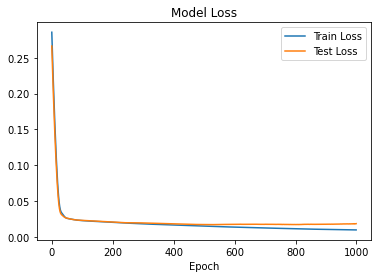

In [16]:
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.legend()

plt.savefig('figures/training_loss.png')
plt.show()

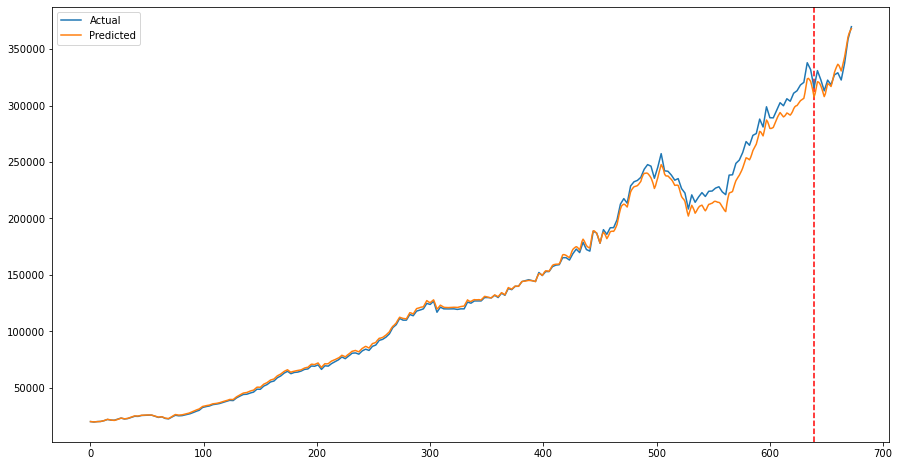

In [17]:
# Plot predictions vs actual

def inverse_pct_change(series, y_0):
    np_series = np.array(series)  # Use np array for built in cumsum
    np_series[0] = np.log(y_0)
    cumulative_sum = np_series.cumsum()
    
    return np.exp(cumulative_sum)


# Get data into the right format
X_tensors = torch.Tensor(X_seq)
y_tensors = torch.Tensor(y_seq)

X_tensors = torch.reshape(X_tensors, (X_tensors.shape[0], IN_SEQ_LENGTH, X_tensors.shape[2]))

# Get predictions and actual
predictions_scaled = lstm1(X_tensors).data.numpy()  # Convert to numpy for plotting
actual_scaled = y_tensors.data.numpy()

# Reverse scaling transformations
predictions_seq = minmax_scaler.inverse_transform(predictions_scaled)  # y values used minmax scaler earlier
actual_seq = minmax_scaler.inverse_transform(actual_scaled)

# Reverse sequence transformations
predictions = [predictions_seq[i][0] for i in range(len(predictions_seq))]
actual = [actual_seq[i][0] for i in range(len(actual_seq))]

# Reverse log difference transformations
first_idx = IN_SEQ_LENGTH

first_target = df_raw['MSPUS'].iat[first_idx]  # First MSPUS value before log differencing
predictions_final = inverse_pct_change(predictions, first_target)
actual_final = inverse_pct_change(actual, first_target)

# Plot
plt.figure(figsize=(15, 8))


train_test_cutoff = round((1-TEST_SIZE) * X_tensors.shape[0])  # Index where test data starts
plt.axvline(x=train_test_cutoff, c='red', linestyle='--')

plt.plot(actual_final, label='Actual')
plt.plot(predictions_final, label='Predicted')
plt.legend()
plt.savefig('figures/actual_vs_predicted.png')

plt.show()

In [18]:
print(actual_final[-(OUT_SEQ_LENGTH+1)])
print(len(actual_final))
print(len(y))

328997.03
673
707


In [30]:
# Predict future based only on last in sequence length

# Get last MSPUS value before start of predictions
FIRST_TARGET = actual_final[-(OUT_SEQ_LENGTH+1)]  

def get_predictions(model, X_test_tensors, first_target):
    # Predictions
    test_predictions = model(X_test_tensors[-1].unsqueeze(0)).detach().numpy()  # Get the last sample
    test_predictions = minmax_scaler.inverse_transform(test_predictions)  # Reverse scaling transform
    test_predictions = test_predictions[0].tolist()
    test_predictions = inverse_pct_change(test_predictions, first_target)
    
    return test_predictions



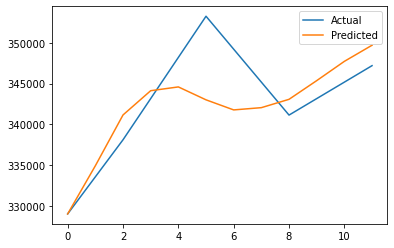

In [31]:


test_predictions = get_predictions(lstm1, X_val_tensors, FIRST_TARGET)

# Actual
test_actual = y_val_tensors[-1].detach().numpy()  # Last actual y
test_actual = minmax_scaler.inverse_transform(test_actual.reshape(1, -1))
test_actual = test_actual[0].tolist()
test_actual = inverse_pct_change(test_actual, FIRST_TARGET)

plt.plot(test_actual, label="Actual")
plt.plot(test_predictions, label="Predicted")
plt.legend()
plt.savefig('figures/actual_vs_predicted_end.png')

plt.show()

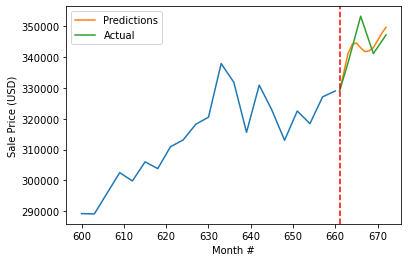

In [36]:
# Full scale actual vs predicted plot

def plot_actual_vs_pred(test_predictions, test_actual, actual_final, plot_savename):
    N = len(actual_final)

    actual_slice = [i for i in range(600, N - OUT_SEQ_LENGTH)]
    pred_slice = [i for i in range(N - OUT_SEQ_LENGTH, N)]
    plt.plot(actual_slice, actual_final[600:N - OUT_SEQ_LENGTH])
    plt.plot(pred_slice, test_predictions, label='Predictions')
    plt.plot(pred_slice, test_actual, label='Actual')
    plt.axvline(x=len(actual_final)-OUT_SEQ_LENGTH, c='red', linestyle='--')


    plt.legend()
    plt.xlabel('Month #')
    plt.ylabel('Sale Price (USD)')
    plt.savefig(plot_savename, bbox_inches='tight')
    plt.show()
    
plot_name = 'figures/scale_actual_vs_pred.png'
plot_actual_vs_pred(test_predictions, test_actual, actual_final, plot_name)

### Run Multiple Models

In [33]:
all_predictions = []
for i in range(2):
    torch.manual_seed(i)
    
    model = LSTM(N_CLASSES,
            INPUT_SIZE,
            HIDDEN_SIZE,
            N_LAYERS
           )
    print('------------TRAINING MODEL {}--------------'.format(i+1))
    train_loss, test_loss = train_model(model)
    
    all_predictions.append(get_predictions(model, X_val_tensors, FIRST_TARGET))


------------TRAINING MODEL 1--------------
Epoch 0: Train loss: 0.28468713 Test loss: 0.267623275518417
Epoch 100: Train loss: 0.02319304 Test loss: 0.024214563891292
Epoch 200: Train loss: 0.02056530 Test loss: 0.021476976573467
Epoch 300: Train loss: 0.01921513 Test loss: 0.020859571173787
Epoch 400: Train loss: 0.01805618 Test loss: 0.020589176565409
Epoch 500: Train loss: 0.01699006 Test loss: 0.020387519150972
Epoch 600: Train loss: 0.01589321 Test loss: 0.019797081127763
Epoch 700: Train loss: 0.01487112 Test loss: 0.019314117729664
Epoch 800: Train loss: 0.01398172 Test loss: 0.018853854387999
Epoch 900: Train loss: 0.01314178 Test loss: 0.018481109291315
------------TRAINING MODEL 2--------------
Epoch 0: Train loss: 0.32212231 Test loss: 0.310914307832718
Epoch 100: Train loss: 0.02275124 Test loss: 0.022610921412706
Epoch 200: Train loss: 0.02045526 Test loss: 0.020523110404611
Epoch 300: Train loss: 0.01888385 Test loss: 0.019816782325506
Epoch 400: Train loss: 0.01778485 Te

In [35]:
np_pred = np.array(all_predictions)

print(np_pred)
print(np_pred.mean(axis=0))
print(np_pred.std(axis=0))

[[328997.0345277  332969.53906768 335742.86323539 336499.56909798
  337360.62314909 338323.15930962 339323.17868133 340443.92407797
  341894.55595051 343743.57914497 345779.37112677 348101.4447778 ]
 [328997.0345277  332946.35447503 336119.32256847 337205.55538365
  337682.32369528 337919.8439752  339198.80753876 341366.70578676
  344052.58711625 346493.15042004 348178.23443287 349660.73975682]]
[328997.0345277  332957.94677135 335931.09290193 336852.56224081
 337521.47342219 338121.50164241 339260.99311005 340905.31493236
 342973.57153338 345118.3647825  346978.80277982 348881.09226731]
[   0.           11.59229632  188.22966654  352.99314284  160.85027309
  201.65766721   62.18557129  461.39085439 1079.01558287 1374.78563753
 1199.43165305  779.64748951]


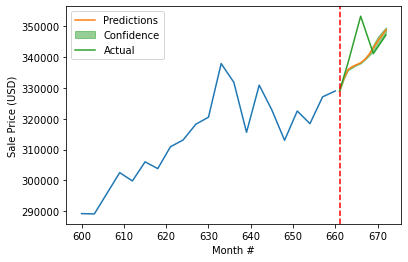

In [40]:
# Plot model average predictions with std devs

def plot_actual_vs_pred_multimodel(test_predictions, test_actual, actual_final, plot_savename):
    N = len(actual_final)
    
    test_predictions = np.array(test_predictions)
    avg_pred = test_predictions.mean(axis=0)
    std_pred = test_predictions.std(axis=0)

    actual_slice = [i for i in range(600, N - OUT_SEQ_LENGTH)]
    pred_slice = [i for i in range(N - OUT_SEQ_LENGTH, N)]
    plt.plot(actual_slice, actual_final[600:N - OUT_SEQ_LENGTH])
    plt.plot(pred_slice, avg_pred, label='Predictions')
    plt.fill_between(pred_slice,  # Fill confidence inter
                     avg_pred + std_pred, 
                     avg_pred - std_pred, 
                     alpha=0.5, 
                     color='C2', 
                     label='Confidence')
    plt.plot(pred_slice, test_actual, label='Actual')
    plt.axvline(x=len(actual_final)-OUT_SEQ_LENGTH, c='red', linestyle='--')


    plt.legend()
    plt.xlabel('Month #')
    plt.ylabel('Sale Price (USD)')
    plt.savefig(plot_savename, bbox_inches='tight')
    plt.show()
    

plot_name = 'figures/actual_vs_pred_multimodel.png'
plot_actual_vs_pred_multimodel(all_predictions, test_actual, actual_final, plot_name)

### Sanity Check Functions

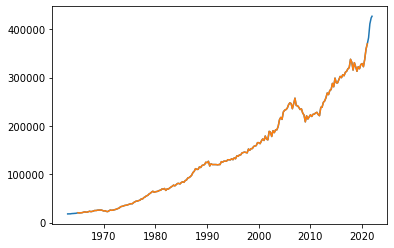

DatetimeIndex(['1963-01-01', '1963-02-01', '1963-03-01', '1963-04-01',
               '1963-05-01', '1963-06-01', '1963-07-01', '1963-08-01',
               '1963-09-01', '1963-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='DATE', length=708, freq=None)
DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01'],
              dtype='datetime64[ns]', name='DATE', length=673, freq=None)


In [23]:
# Reverse transform sanity check
actual_df = pd.DataFrame(actual_final, index=df_raw['MSPUS'].index[first_idx:-11])

plt.plot(df_raw['MSPUS'], label='Raw')
plt.plot(actual_df, label='Transformed')

plt.show()
print(df_raw['MSPUS'].index)
print(actual_df.index)

In [24]:
# Test inverse_pct_change

np.random.seed(0)

s = pd.Series(np.random.randint(100000, 300000, size=10))

print(s.values)

t = np.log(s).diff()
t.iat[0] = np.log(s.iat[0])
res = np.exp(t.cumsum())

print(res.values)

test = inverse_pct_change(t, s.iat[0])
print(test)

[299340 143567 273685 217952 276963 252315 195939 197639 141993 222579]
[299340. 143567. 273685. 217952. 276963. 252315. 195939. 197639. 141993.
 222579.]
[299340. 143567. 273685. 217952. 276963. 252315. 195939. 197639. 141993.
 222579.]
